In [88]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [89]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [90]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
test_label = test[:,0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

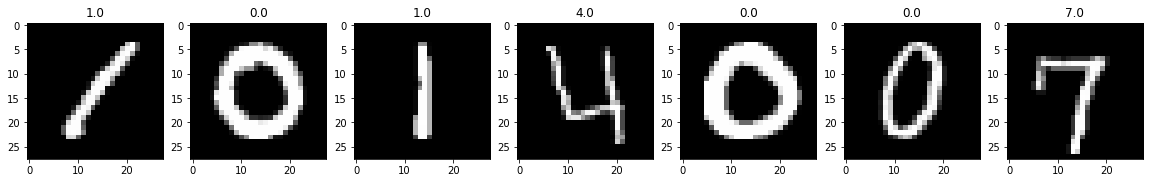

In [91]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:7], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [92]:
y_train = train_label
X_train = train_img.reshape(-1, 28 * 28).astype(np.float32)

In [93]:
X_train_mean = X_train.mean(axis=0)
X_train -= X_train_mean

In [94]:
cov_matrix = np.dot(X_train.T, X_train) / X_train.shape[0]

In [95]:
U, S, _ = np.linalg.svd(cov_matrix)

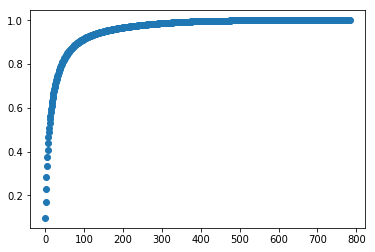

In [96]:
S_cumsum = np.cumsum(S) / np.sum(S)
plt.plot(S_cumsum, 'o')

In [97]:
S_thr = 0.8  # порог

# число компонент для заданного порога
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))

print('n_comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n_comp=42 S=0.800


In [98]:
X_train_reduced = np.dot(X_train, U[:, :n_comp])

In [99]:
X_train_reduced.shape

(42000, 42)

In [100]:
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

In [103]:
clf1 = RandomForestClassifier(random_state=1,n_estimators=15, n_jobs=7)
clf2 = GaussianNB()
clmeta = KNeighborsClassifier(n_neighbors=1,n_jobs=7)
sclf = StackingClassifier(classifiers=[clf1, clf2], use_probas=True,
                          average_probas=False,
                          meta_classifier=clmeta)

In [108]:
%%time
for clf, label in zip([clf1, clf2,clmeta,sclf], 
                      ['Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier (KNN)']):

    scores = model_selection.cross_val_score(clf, X_train_reduced, y_train, 
                                              cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

Accuracy: 0.93 (+/- 0.00) [Random Forest]
Accuracy: 0.87 (+/- 0.00) [Naive Bayes]
Accuracy: 0.97 (+/- 0.00) [StackingClassifier (KNN)]
Wall time: 15.9 s


In [105]:
from sklearn.model_selection import GridSearchCV

In [106]:
%%time
params = {'randomforestclassifier__n_estimators': [5, 10, 50],
          'meta-kneighborsclassifier__n_neighbors': [1, 5]}
grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X_train_reduced, y_train)

Wall time: 2min 32s


In [107]:
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'meta-kneighborsclassifier__n_neighbors': 5, 'randomforestclassifier__n_estimators': 50}
Accuracy: 0.95


In [109]:
y_test = test_label
X_test = test_img.reshape(-1, 28 * 28).astype(np.float32)
X_test_reduced = np.dot(X_test, U[:, :n_comp])
X_test_reduced.shape

(28000, 42)

In [110]:
y_pred = grid.best_estimator_.predict(X_test_reduced)
y_pred.shape

(28000,)

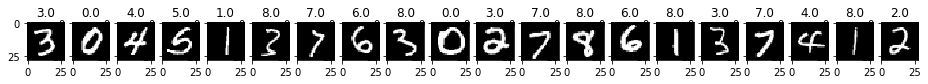

In [121]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[160:180], 1):
    subplot = fig.add_subplot(1, 25, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % y_pred[i+ 160 - 1]);

In [122]:
with open('submit.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_pred, 1):
        dst.write('%s,%s\n' % (i, p.astype(np.int)))